In [ ]:
import json
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from torch.utils.data import TensorDataset, DataLoader

In [ ]:
nltk.download("stopwords")
nltk.download("wordnet")
stopwords = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


**Loading & Pre-processing Data**

In [ ]:
lemmatizer = WordNetLemmatizer()
def normalize_elongated_words(text):
    words = text.split()
    normalized_words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(normalized_words)

def clean_text(text):
    text = text.lower()  # Lowercasing
    text = re.sub(r"http\S+|www\S+", "", text)  # Hapus URL
    text = re.sub(r"\[.*?\]\(http\S+?\)", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Hapus karakter khusus
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)  # Reduce "offffff" to "offf"

    text = normalize_elongated_words(text)  # Apply lemmatization to normalize words

    # Hapus stopwords
    text = " ".join([word for word in text.split() if word not in stopwords])

    return text.strip()


In [ ]:
# Train Dataframe
data = []
with open("gold_train.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        entry = json.loads(line)
        data.append({
            "label": entry["label"],
            "cleaned_context": clean_text(entry["context"]),
            "cleaned_target": clean_text(entry["target"])
        })

df = pd.DataFrame(data)

# Validation Dataframe
val_data = []
with open("gold_val.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        entry = json.loads(line)
        val_data.append({
            "label": entry["label"],
            "cleaned_context": clean_text(entry["context"]),
            "cleaned_target": clean_text(entry["target"])
        })

val_df = pd.DataFrame(val_data)

# Test Dataframe
test_data = []
with open("gold_test.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        entry = json.loads(line)
        test_data.append({
            "label": entry["label"],
            "cleaned_context": clean_text(entry["context"]),
            "cleaned_target": clean_text(entry["target"])
        })

test_df = pd.DataFrame(test_data)

In [ ]:
import torch
from transformers import AutoTokenizer
from transformers import DistilBertTokenizer, DistilBertModel

**Word Embedding / Vectorizer**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenization with [SEP] between context & target
tokenized_data = tokenizer(
    df["cleaned_context"].tolist(),
    df["cleaned_target"].tolist(),
    padding="max_length",
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

# Extract tokenized tensors
input_ids = tokenized_data["input_ids"]
attention_mask = tokenized_data["attention_mask"]

# Print example tokenized data
print("\nExample Tokenized IDs:\n", input_ids[:2])
print("\nExample Attention Masks:\n", attention_mask[:2])

# Decode first tokenized example
decoded_text = tokenizer.decode(input_ids[0], skip_special_tokens=False)
print("\nDecoded Text:\n", decoded_text)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


Example Tokenized IDs:
 tensor([[  101,  2866, 21746,  ...,     0,     0,     0],
        [  101,  4952,  9866,  ...,     0,     0,     0]])

Example Attention Masks:
 tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

Decoded Text:
 [CLS] uk fucked [SEP] uk world fucked ftfy [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [ ]:
df["label"] = df["label"].astype(int)
labels = torch.tensor(df["label"].tolist())  # 0 = hate, 1 = neutral, 2 = counter-hate

In [ ]:
dataset = TensorDataset(input_ids, attention_mask, labels)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

**Training Model**

In [ ]:
import torch.nn as nn
from transformers import DistilBertModel

class CustomDistilBERTClassifier(nn.Module):
    def __init__(self):
        super(CustomDistilBERTClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 3)  # 3 classes

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state
        pooled_output = hidden_state[:, 0]
        dropped = self.dropout(pooled_output)
        logits = self.classifier(dropped)

        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

In [ ]:
model = CustomDistilBERTClassifier()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=1e-5)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
model.train()

for epoch in range(2):
    total_loss = 0
    for batch in dataloader:
        b_input_ids, b_attention_mask, b_labels = [x.to(device) for x in batch]

        optimizer.zero_grad()
        outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask, labels=b_labels)

        loss = outputs["loss"]
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}")

Epoch 1, Loss: 1.0400
Epoch 2, Loss: 0.9932


**Model Evaluation**

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import torch.nn.functional as F
import numpy as np

In [ ]:
def evaluate(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            b_input_ids, b_attention_mask, b_labels = [x.to(device) for x in batch]

            outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask)
            logits = outputs["logits"]
            preds = torch.argmax(F.softmax(logits, dim=1), dim=1)

            # Collect predictions and actual labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(b_labels.cpu().numpy())

    # Metrics
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

    return acc, precision, recall, f1, all_preds

def create_dataloader(df, tokenizer, max_length=512, batch_size=16):
    tokenized_data = tokenizer(
        df["cleaned_context"].tolist(),
        df["cleaned_target"].tolist(),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    input_ids = tokenized_data["input_ids"]
    attention_mask = tokenized_data["attention_mask"]

    # Convert labels to tensor
    labels = torch.tensor(pd.to_numeric(df["label"]).tolist())
    # Wrapping into TensorDataset
    dataset = TensorDataset(input_ids, attention_mask, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    return dataloader

In [ ]:
# Save Model
torch.save(model.state_dict(), "custom_distilbert_model.pt")

In [ ]:
import time
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Create dataloaders for validation and test sets
val_dataloader = create_dataloader(val_df, tokenizer)
test_dataloader = create_dataloader(test_df, tokenizer)

start_time = time.time()

# Evaluate on validation set
val_acc, val_precision, val_recall, val_f1, val_preds = evaluate(model, val_dataloader)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1-score: {val_f1:.4f}")


# Evaluate on test set
test_acc, test_precision, test_recall, test_f1, test_preds = evaluate(model, test_dataloader)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1:.4f}")

end_time = time.time()
computational_time = end_time - start_time
print(f"Computational Time: {computational_time:.4f} seconds")


Validation Accuracy: 0.5456
Validation Precision: 0.4883
Validation Recall: 0.4469
Validation F1-score: 0.4281
Test Accuracy: 0.5330
Test Precision: 0.4831
Test Recall: 0.4338
Test F1-score: 0.4055
Computational Time: 20.0365 seconds


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='coolwarm',
        xticklabels=labels,
        yticklabels=labels
    )

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
print(val_df['label'].unique())

['2' '1' '0']


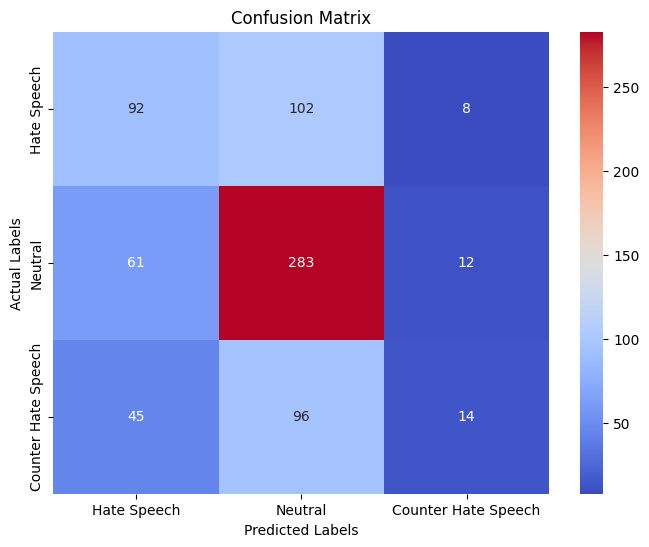

In [ ]:
val_true = [int(label) for label in val_df['label'].tolist()]
val_preds = [int(pred) for pred in val_preds]

plot_confusion_matrix(val_true, val_preds, ['Hate Speech', 'Neutral', 'Counter Hate Speech'])

**Note: Majority are predicted as Label 1, as they are the majority in the dataset (Class Imbalance)**

**Obtain Misclassified Instances**

In [ ]:
import torch.nn.functional as F

def get_misclassified_examples(model, dataloader, df, tokenizer, device='cpu'):
    model.eval()
    model.to(device)

    label_map = {
        0: "Hate",
        1: "Neutral",
        2: "Counter-Hate"
    }

    misclassified = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs['logits']
            probs = F.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    row_index = batch_idx * dataloader.batch_size + i

                    parent_text = df.iloc[row_index]["cleaned_context"]
                    target_text = df.iloc[row_index]["cleaned_target"]
                    confidence_score = probs[i][preds[i]].item()

                    misclassified.append({
                        'index': row_index,
                        'parent': parent_text,
                        'target': target_text,
                        'true_label': label_map[labels[i].item()],
                        'predicted_label': label_map[preds[i].item()],
                        'confidence': round(confidence_score, 4)
                    })

    print(f"\nTotal Misclassified: {len(misclassified)}")
    # Configure -> How many samples shown
    for m in misclassified[:]:
        print("\n---")
        print(f"Index: {m['index']}")
        print(f"True Label: {m['true_label']}, Predicted Label: {m['predicted_label']} ({m['confidence'] * 100:.2f}%)")
        print(f"Parent: {m['parent']}")
        print(f"Target: {m['target']}")

    return misclassified


In [ ]:
misclassified_df = get_misclassified_examples(
    model=model,
    dataloader=val_dataloader,
    df=val_df,
    tokenizer=tokenizer,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)


Total Misclassified: 324

---
Index: 0
True Label: Counter-Hate, Predicted Label: Neutral (45.91%)
Parent: fact think sufficient raping child disgusting registered sex offended punishment right society know punishment prison got none funny defend condemn woman almost like youre even concerned protecting child making sure woman arent getting extra rape victim woman rapist men male rapist never jailed
Target: able find job 20 year sound like fucking punishment

---
Index: 1
True Label: Counter-Hate, Predicted Label: Neutral (39.21%)
Parent: true fucking liar even top three
Target: cant handle truth hmm

---
Index: 4
True Label: Hate, Predicted Label: Counter-Hate (36.23%)
Parent: think view ha validity though many woman growing conditioned concede patriarchal figure comparison men im saying woman submissive men saying men always dominant woman gender binary society enforced image ideal cooperative supportive woman woman continually grow likely concede without fight case conflict men con

**PCA Technique Implementation**

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

all_hidden_states = []
for batch in val_dataloader:
    b_input_ids, b_attention_mask, b_labels = [x.to(device) for x in batch]
    with torch.no_grad():
        outputs = model.bert(input_ids=b_input_ids, attention_mask=b_attention_mask).last_hidden_state
        hidden_state = outputs[:, 0].cpu().numpy()
    all_hidden_states.extend(hidden_state)
all_hidden_states = np.array(all_hidden_states)

# Number of Components
pca = PCA(n_components=10)
principal_components = pca.fit_transform(all_hidden_states)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Principal Components Shape:", principal_components.shape)


Explained variance ratio: [0.26990452 0.09168297 0.05336171 0.04275523 0.0323039  0.02866658
 0.02295679 0.02284165 0.01925844 0.01645177]
Principal Components Shape: (713, 10)


In [ ]:
plt.figure(figsize=(8, 6))
for label in df_pca['label'].unique():
    subset = df_pca[df_pca['label'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=label)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Hidden States from Hate Speech Dataset')
plt.legend()
plt.grid(True)
plt.show()